In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Load the DataFrame from the CSV file
df = pd.read_csv('grad_cam_RVL_dataset.csv')

# Extracting the relevant columns to create the final DataFrame
df = df.drop(['image_path'], axis=1)
df

,Image,Label
0,80035521.tif,15
1,513280028.tif,1
2,2053453161.tif,7
3,2040792992_2040792994.tif,10
4,522787731+-7732.tif,3
...,...,...
20011,tob07624.54.tif,9
20012,11291802.tif,14
20013,60001267.tif,14
20014,10402944.tif,6


In [3]:

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
output_directory = 'C:/Users/HP/Desktop/Projet/CODE/RVL_dataset/'
NUM_CLASSES = 16  


# Custom Dataset Class
class TIFDataset(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load dataset
dataset = TIFDataset(output_directory, df, transform=transform)

In [4]:
# Split dataset
train_size = int(0.5 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
torch.cuda.empty_cache()

  - **CNN basic model**

In [ ]:


# Define a basic CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = CNN(NUM_CLASSES)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)



  - **Pretrained CNN Model EfficientnetB0**

In [6]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)
# Modify the classifier to fit our number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

  - **Training test**

In [7]:

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 1.4179
Epoch 2/10, Loss: 0.9619
Epoch 3/10, Loss: 0.7983
Epoch 4/10, Loss: 0.6681
Epoch 5/10, Loss: 0.5849
Epoch 6/10, Loss: 0.4800
Epoch 7/10, Loss: 0.4337
Epoch 8/10, Loss: 0.3559
Epoch 9/10, Loss: 0.3035
Epoch 10/10, Loss: 0.2707


  - **Validation test**

In [8]:
# Validation loop
model.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Validation Loss: 1.0063, Accuracy: 0.7777


 - **Testing test**

Test Loss: 1.0063, Accuracy: 0.7770


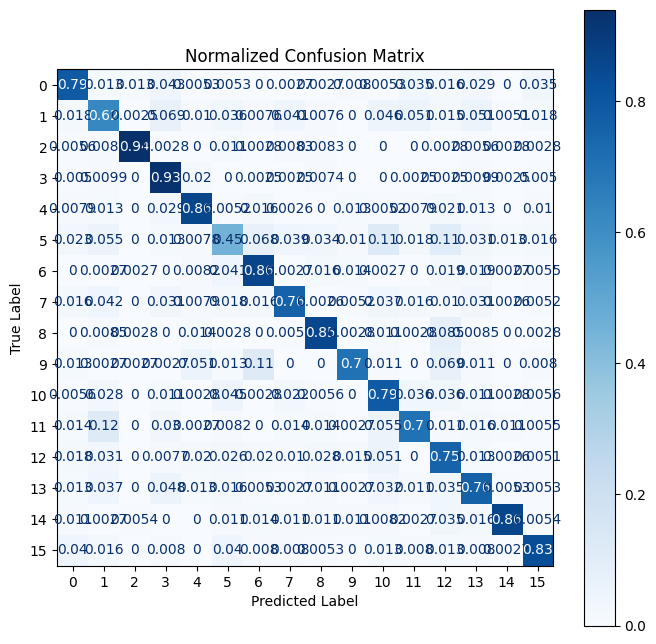

In [11]:

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(NUM_CLASSES)])
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()
